In [1]:
!pip install yellowbrick

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import cluster, metrics
from sklearn.cluster import KMeans , AgglomerativeClustering
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.datasets.loaders import load_nfl

## Normalisation des données

Maintenant que nous avons notre jeu de données complet pour l'analyse, nous avons deux opérations à effectuer pour commencer : 
- tout d'abord, nous avons utilisé une matrice de contingence pour vérifier que les variables que nous avons choisi ne sont pas significativement corrélées entre elles
- on effectue ensuite une opération de normalisation sur les données pour harmoniser l'ensemble (l'analyse par composantes principales porte sur les vecteurs de données et non pas sur les valeurs en elles-mêmes, il est donc préférable de normaliser les données pour éviter que certaines valeurs écrasent trop les autres durant les calculs)

In [3]:
tableau_donnees_2020_v2 = pd.read_csv("tableau_donnees_openclassrooms.csv")
tableau_donnees_2020_v2.drop(columns=["Index"],inplace=True)
tableau_donnees_2020_v2

,Area,Country Code,Nombre habitants,Production,Importations,Exportations,Variation de stock,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité intérieure (milliers de tonnes),PIB par habitant
0,Afghanistan,AFG,38928350.0,28.0,36.0,0.0,-2.0,5.98,62.0,517.449409
1,Albania,ALB,2877800.0,14.0,26.0,0.0,0.0,71.27,40.0,5268.863092
2,Algeria,DZA,43851040.0,284.0,0.0,1.0,3.0,22.04,286.0,3323.609265
3,Angola,AGO,32866270.0,52.0,224.0,0.0,0.0,28.19,276.0,1528.660485
4,Antigua and Barbuda,ATG,97930.0,0.0,6.0,0.0,0.0,264.83,6.0,14462.862740
...,...,...,...,...,...,...,...,...,...,...
171,Uzbekistan,UZB,33469200.0,66.0,44.0,0.0,7.0,9.20,117.0,1799.406657
172,Vanuatu,VUT,307140.0,1.0,4.0,0.0,0.0,50.02,5.0,2960.933267
173,Viet Nam,VNM,97338580.0,1319.0,236.0,17.0,0.0,61.09,1538.0,3560.928772
174,Zambia,ZMB,18383960.0,52.0,21.0,9.0,15.0,8.83,79.0,985.132617


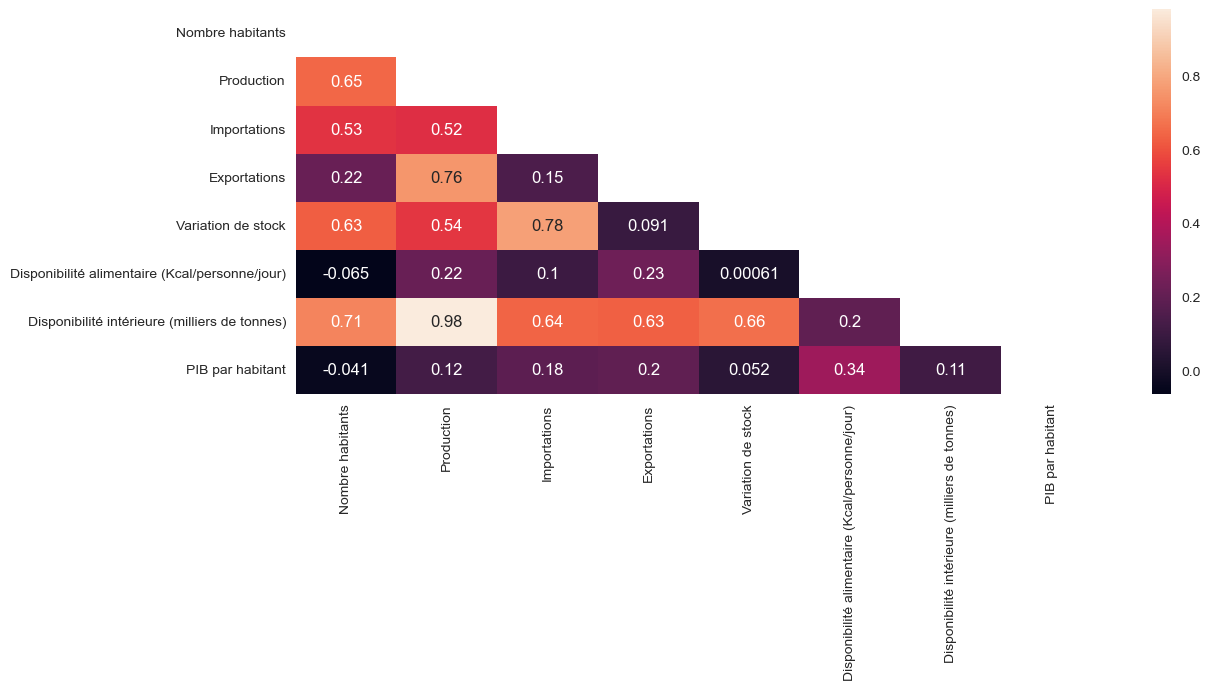

In [4]:
matrix_2 = tableau_donnees_2020_v2.corr()
mask = np.triu(np.ones_like(matrix_2, dtype=np.bool_))
plt.figure(figsize=(13, 5))
sns.heatmap(matrix_2, mask=mask, annot=True)
plt.show()

In [5]:
noms_pays = tableau_donnees_2020_v2[["Area","Country Code"]]
noms_pays

,Area,Country Code
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,Angola,AGO
4,Antigua and Barbuda,ATG
...,...,...
171,Uzbekistan,UZB
172,Vanuatu,VUT
173,Viet Nam,VNM
174,Zambia,ZMB


In [6]:
noms_colonnes = tableau_donnees_2020_v2.columns
noms_colonnes = noms_colonnes.drop(["Area","Country Code"])
noms_colonnes

Index(['Nombre habitants', 'Production', 'Importations', 'Exportations',
       'Variation de stock', 'Disponibilité alimentaire (Kcal/personne/jour)',
       'Disponibilité intérieure (milliers de tonnes)', 'PIB par habitant'],
      dtype='object')

In [7]:
tableau_donnees_2020_matrice = tableau_donnees_2020_v2.drop(columns=["Area","Country Code"])
tableau_donnees_2020_matrice = tableau_donnees_2020_matrice.values
tableau_donnees_2020_matrice

array([[3.89283500e+07, 2.80000000e+01, 3.60000000e+01, ...,
        5.98000000e+00, 6.20000000e+01, 5.17449409e+02],
       [2.87780000e+06, 1.40000000e+01, 2.60000000e+01, ...,
        7.12700000e+01, 4.00000000e+01, 5.26886309e+03],
       [4.38510400e+07, 2.84000000e+02, 0.00000000e+00, ...,
        2.20400000e+01, 2.86000000e+02, 3.32360927e+03],
       ...,
       [9.73385800e+07, 1.31900000e+03, 2.36000000e+02, ...,
        6.10900000e+01, 1.53800000e+03, 3.56092877e+03],
       [1.83839600e+07, 5.20000000e+01, 2.10000000e+01, ...,
        8.83000000e+00, 7.90000000e+01, 9.85132617e+02],
       [1.48629200e+07, 6.70000000e+01, 1.00000000e+00, ...,
        1.54600000e+01, 6.80000000e+01, 1.44720542e+03]])

In [8]:
scaler = StandardScaler()
tableau_donnees_2020_scaled = scaler.fit_transform(tableau_donnees_2020_matrice)
tableau_donnees_2020_scaled

array([[-0.02950044, -0.27057928, -0.24207275, ..., -1.17072525,
        -0.27374848, -0.6878355 ],
       [-0.26047447, -0.27578818, -0.28354535, ..., -0.12795591,
        -0.28230761, -0.44016392],
       [ 0.00203898, -0.17533091, -0.39137411, ..., -0.9142254 ,
        -0.18660097, -0.54156197],
       ...,
       [ 0.34473092,  0.20975528,  0.58737928, ..., -0.29054424,
         0.30049134, -0.52919148],
       [-0.1611273 , -0.26164975, -0.30428165, ..., -1.12520691,
        -0.26713461, -0.6634571 ],
       [-0.18368642, -0.25606879, -0.38722685, ..., -1.01931687,
        -0.27141417, -0.63937115]])

In [9]:
tableau_donnees_2020_v3 = pd.DataFrame(tableau_donnees_2020_scaled,columns = noms_colonnes)
tableau_donnees_2020_v3 = pd.merge(noms_pays,tableau_donnees_2020_v3,left_index=True,right_index=True)
tableau_donnees_2020_v3

,Area,Country Code,Nombre habitants,Production,Importations,Exportations,Variation de stock,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité intérieure (milliers de tonnes),PIB par habitant
0,Afghanistan,AFG,-0.029500,-0.270579,-0.242073,-0.225655,-0.211746,-1.170725,-0.273748,-0.687835
1,Albania,ALB,-0.260474,-0.275788,-0.283545,-0.225655,-0.191093,-0.127956,-0.282308,-0.440164
2,Algeria,DZA,0.002039,-0.175331,-0.391374,-0.223453,-0.160115,-0.914225,-0.186601,-0.541562
3,Angola,AGO,-0.068340,-0.261650,0.537612,-0.225655,-0.191093,-0.816002,-0.190491,-0.635125
4,Antigua and Barbuda,ATG,-0.278285,-0.280997,-0.366491,-0.225655,-0.191093,2.963458,-0.295535,0.039081
...,...,...,...,...,...,...,...,...,...,...
171,Uzbekistan,UZB,-0.064477,-0.256441,-0.208895,-0.225655,-0.118810,-1.119298,-0.252351,-0.621012
172,Vanuatu,VUT,-0.276945,-0.280625,-0.374785,-0.225655,-0.191093,-0.467347,-0.295924,-0.560467
173,Viet Nam,VNM,0.344731,0.209755,0.587379,-0.188223,-0.191093,-0.290544,0.300491,-0.529191
174,Zambia,ZMB,-0.161127,-0.261650,-0.304282,-0.205838,-0.036200,-1.125207,-0.267135,-0.663457


In [10]:
idx = ["mean", "std"]
tableau_donnees_2020_v3.describe().round(2).loc[idx, :]

,Nombre habitants,Production,Importations,Exportations,Variation de stock,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité intérieure (milliers de tonnes),PIB par habitant
mean,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## Analyse PCA

In [11]:
composants_analyse = 8

In [12]:
pca = PCA(n_components=composants_analyse)

In [13]:
pca.fit(tableau_donnees_2020_scaled)

PCA(n_components=8)

In [14]:
pca.explained_variance_ratio_

array([4.97089567e-01, 1.91853534e-01, 1.37269131e-01, 8.11532073e-02,
       5.21948444e-02, 2.52028943e-02, 1.52368214e-02, 8.83970450e-33])

In [15]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([49.71, 19.19, 13.73,  8.12,  5.22,  2.52,  1.52,  0.  ])

In [16]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 50.,  69.,  83.,  91.,  96.,  98., 100., 100.])

In [17]:
x_list = range(1, composants_analyse+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7, 8]

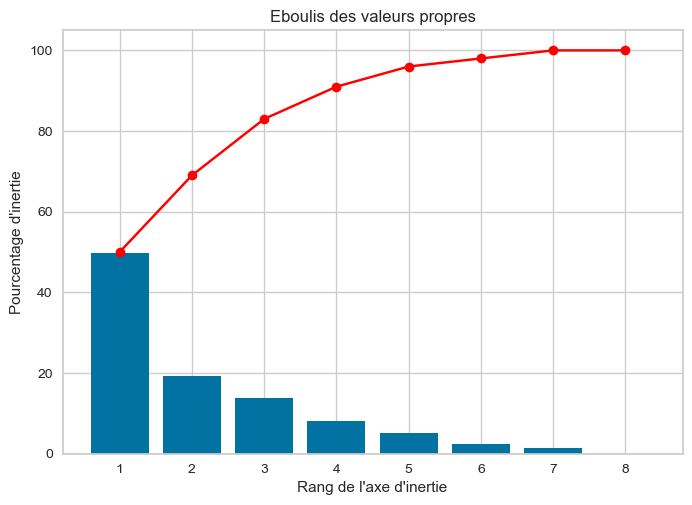

In [18]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [19]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5,6,7
0,3.848197e-01,0.466575,0.379597,0.293877,0.384627,1.040927e-01,0.486053,9.350089e-02
1,-2.956627e-01,0.138466,-0.198013,0.433837,-0.326873,5.677859e-01,0.037243,4.851526e-01
2,5.096272e-02,0.274929,-0.421903,0.490806,-0.320334,-2.966662e-01,0.149114,-5.385764e-01
3,-7.255400e-04,0.005437,-0.011965,0.206292,-0.062550,-7.403829e-01,-0.034244,6.356245e-01
4,7.746432e-01,0.004199,-0.449740,-0.280718,-0.219209,1.405825e-01,0.003542,2.258605e-01
5,2.180367e-01,-0.076589,0.653961,0.039607,-0.712699,-7.412319e-03,-0.052588,-8.124142e-02
6,3.380646e-01,-0.411662,0.067064,0.589050,0.286414,1.038641e-01,-0.517455,-6.471736e-02
7,-2.191683e-16,0.715660,0.064204,-0.120929,0.025786,-3.544979e-17,-0.684412,1.883292e-17


In [20]:
pcs.columns = noms_colonnes
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,Nombre habitants,Production,Importations,Exportations,Variation de stock,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité intérieure (milliers de tonnes),PIB par habitant
F1,0.38,0.47,0.38,0.29,0.38,0.10,0.49,0.09
F2,-0.30,0.14,-0.20,0.43,-0.33,0.57,0.04,0.49
F3,0.05,0.27,-0.42,0.49,-0.32,-0.30,0.15,-0.54
F4,-0.00,0.01,-0.01,0.21,-0.06,-0.74,-0.03,0.64
F5,0.77,0.00,-0.45,-0.28,-0.22,0.14,0.00,0.23
F6,0.22,-0.08,0.65,0.04,-0.71,-0.01,-0.05,-0.08
F7,0.34,-0.41,0.07,0.59,0.29,0.10,-0.52,-0.06
F8,-0.00,0.72,0.06,-0.12,0.03,-0.00,-0.68,0.00


In [21]:
pcs.T

,F1,F2,F3,F4,F5,F6,F7,F8
Nombre habitants,0.384820,-0.295663,0.050963,-0.000726,0.774643,0.218037,0.338065,-2.191683e-16
Production,0.466575,0.138466,0.274929,0.005437,0.004199,-0.076589,-0.411662,7.156602e-01
Importations,0.379597,-0.198013,-0.421903,-0.011965,-0.449740,0.653961,0.067064,6.420416e-02
Exportations,0.293877,0.433837,0.490806,0.206292,-0.280718,0.039607,0.589050,-1.209292e-01
Variation de stock,0.384627,-0.326873,-0.320334,-0.062550,-0.219209,-0.712699,0.286414,2.578602e-02
Disponibilité alimentaire (Kcal/personne/jour),0.104093,0.567786,-0.296666,-0.740383,0.140583,-0.007412,0.103864,-3.544979e-17
Disponibilité intérieure (milliers de tonnes),0.486053,0.037243,0.149114,-0.034244,0.003542,-0.052588,-0.517455,-6.844118e-01
PIB par habitant,0.093501,0.485153,-0.538576,0.635624,0.225861,-0.081241,-0.064717,1.883292e-17


<AxesSubplot:>

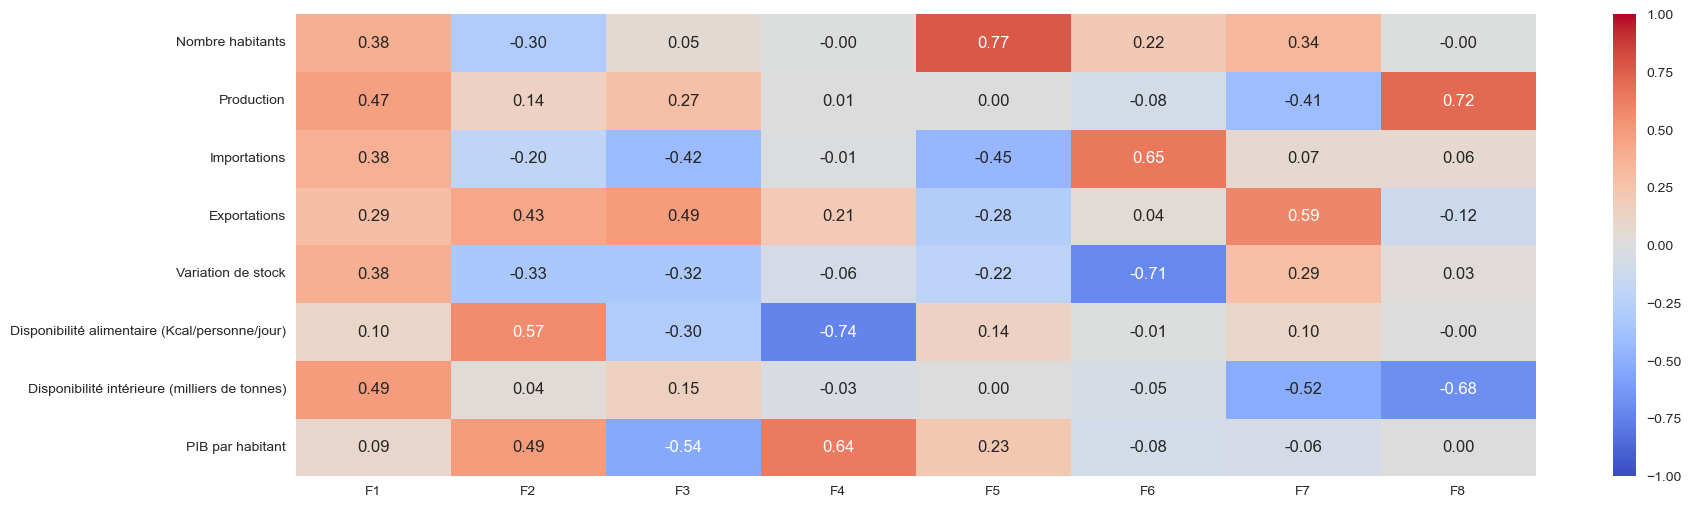

In [22]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

In [23]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    x,y=x_y
    fig, ax = plt.subplots(figsize=(10, 9))
    for i in range(0, pca.components_.shape[1]):
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
        plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  
    plt.axis('equal')
    plt.show(block=False)

In [24]:
x_y = (0,1)
x_y

(0, 1)

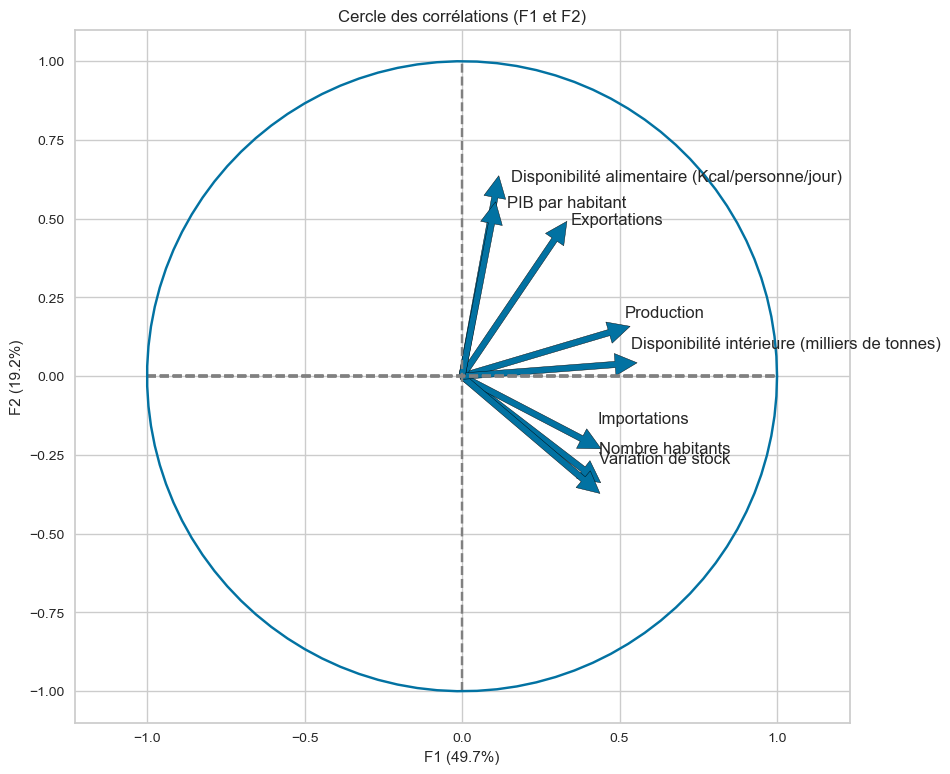

In [25]:
correlation_graph(pca, x_y, noms_colonnes)

Notes concernant les axes F1,F2
- axe F1 : pays producteurs
- axe F2 : pays riches

In [26]:
x_y_2 = (2,3)
x_y_2

(2, 3)

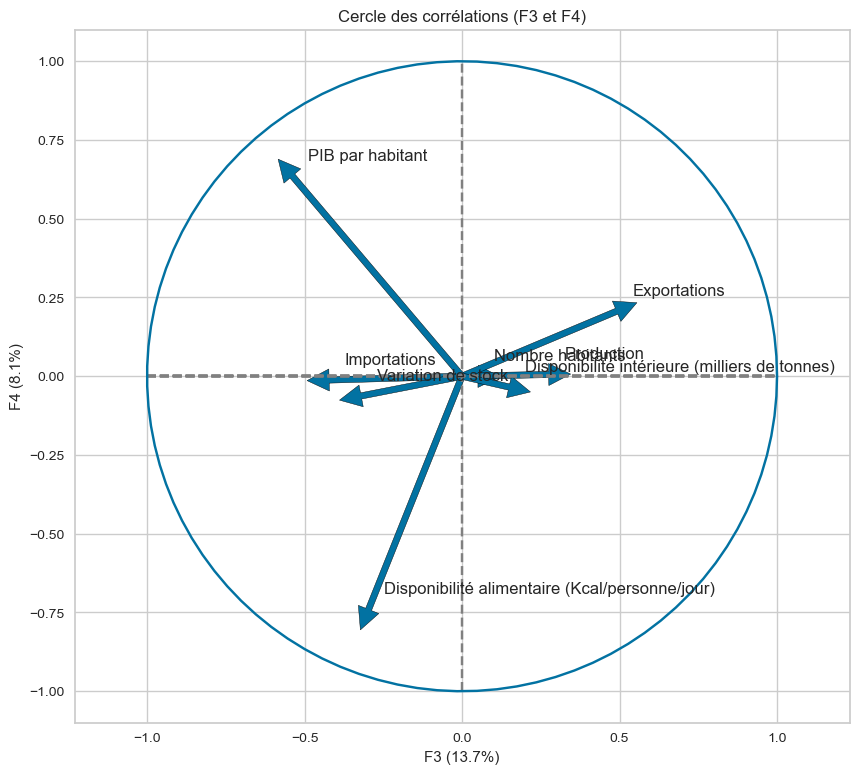

In [27]:
correlation_graph(pca, x_y_2, noms_colonnes)

- F3 : pays transformateurs
- F4 : pays ayant peu de consommation de viande de volaille

In [28]:
X_proj = pca.transform(tableau_donnees_2020_scaled)

In [29]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    X_ = np.array(X_projected)
    if not figsize: 
        figsize = (7,6)

    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e
 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    x, y = x_y
   
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    c = None if clusters is None else clusters
 
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

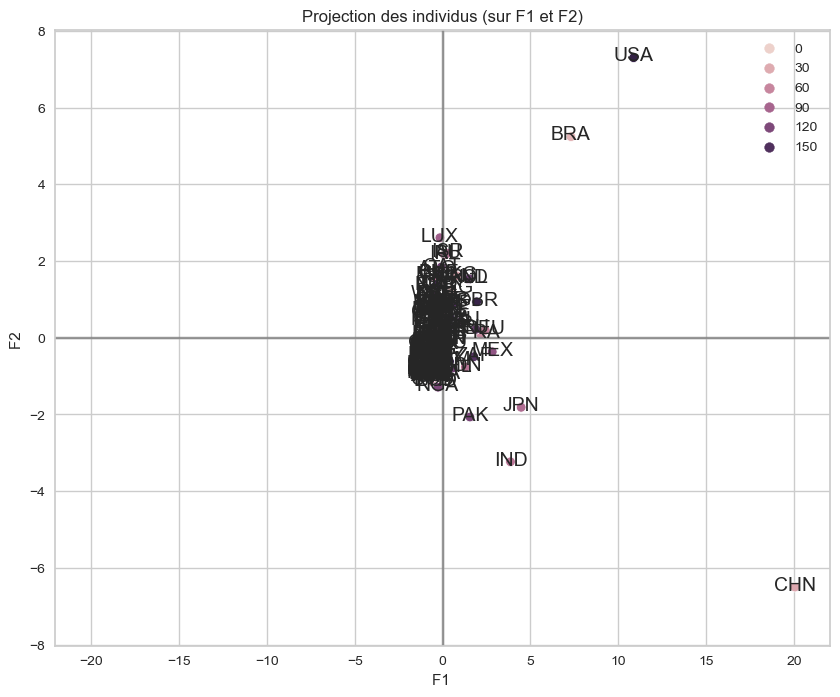

In [30]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, labels=tableau_donnees_2020_v3["Country Code"],clusters=tableau_donnees_2020_v3.index)

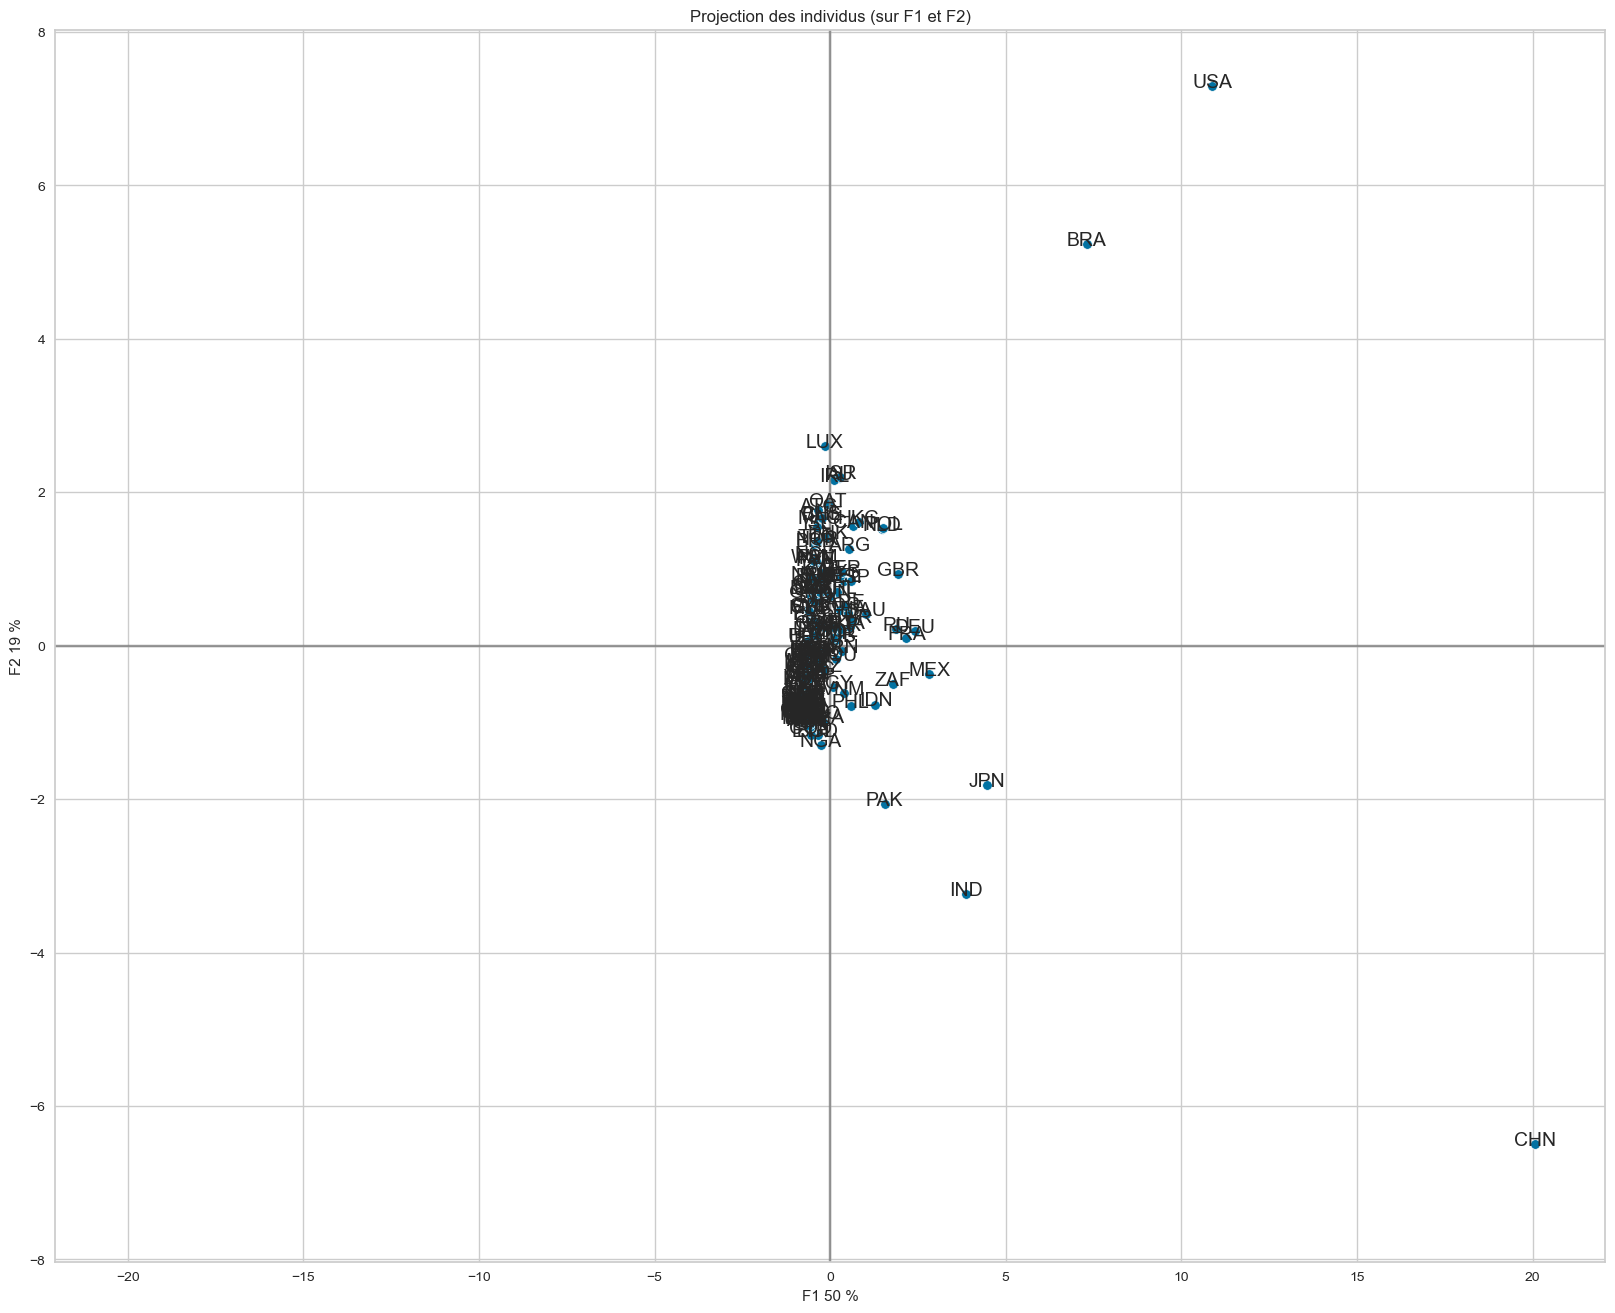

In [31]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y, pca, figsize=(20,16), labels=tableau_donnees_2020_v3["Country Code"], marker="o")

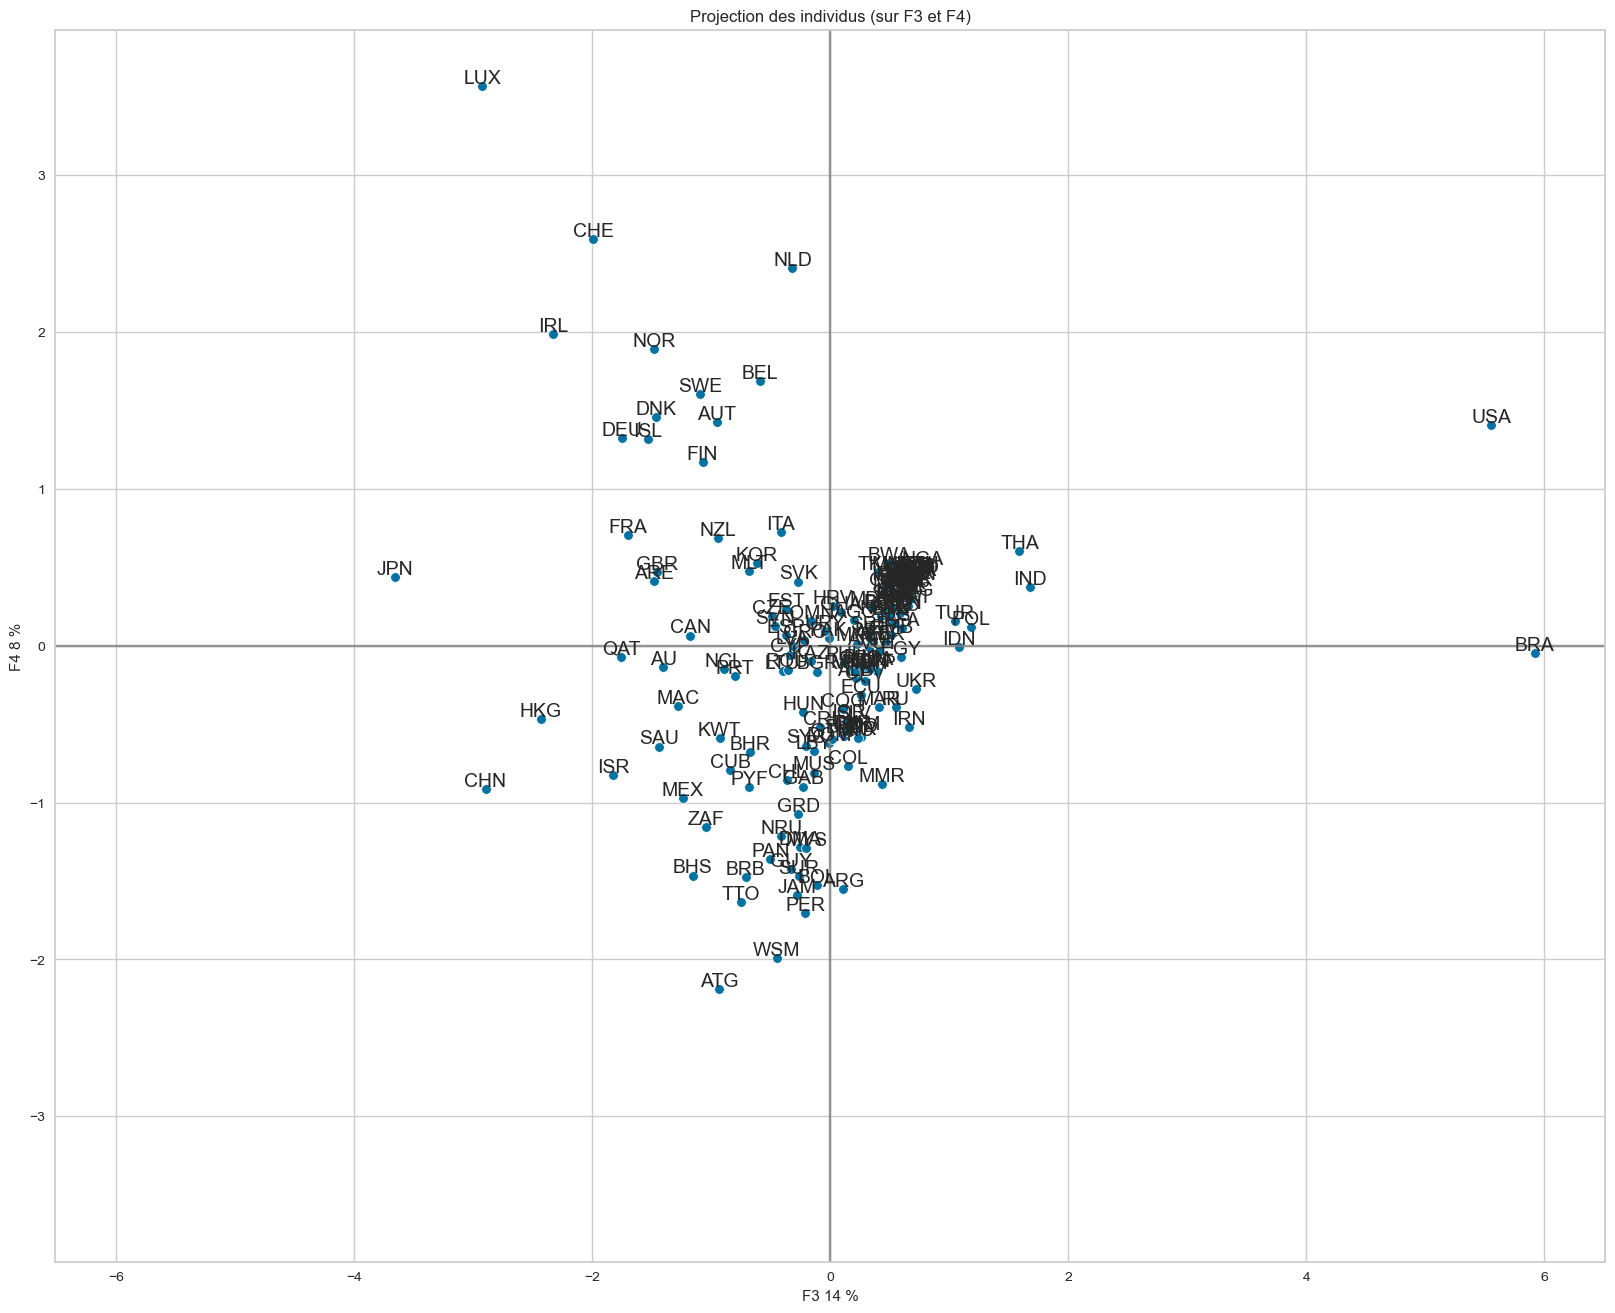

In [32]:
x_y = 2,3
display_factorial_planes(X_proj, x_y, pca, figsize=(20,16),labels=tableau_donnees_2020_v3["Country Code"], marker="o")

## Dendrogrammes

In [33]:
Z = linkage(tableau_donnees_2020_scaled, method="ward")
Z

array([[1.51000000e+02, 1.64000000e+02, 2.48952117e-02, 2.00000000e+00],
       [2.50000000e+01, 3.10000000e+01, 3.78266917e-02, 2.00000000e+00],
       [6.90000000e+01, 9.30000000e+01, 4.95169605e-02, 2.00000000e+00],
       [1.60000000e+01, 5.60000000e+01, 5.11838649e-02, 2.00000000e+00],
       [1.80000000e+01, 4.70000000e+01, 5.21341561e-02, 2.00000000e+00],
       [2.80000000e+01, 4.40000000e+01, 5.24868325e-02, 2.00000000e+00],
       [3.00000000e+01, 1.78000000e+02, 5.35635980e-02, 3.00000000e+00],
       [9.00000000e+01, 1.47000000e+02, 5.36586860e-02, 2.00000000e+00],
       [8.60000000e+01, 1.68000000e+02, 6.22264908e-02, 2.00000000e+00],
       [1.37000000e+02, 1.77000000e+02, 6.49424395e-02, 3.00000000e+00],
       [5.40000000e+01, 1.83000000e+02, 6.87181722e-02, 3.00000000e+00],
       [1.04000000e+02, 1.44000000e+02, 7.65997080e-02, 2.00000000e+00],
       [1.56000000e+02, 1.75000000e+02, 7.79678646e-02, 2.00000000e+00],
       [1.14000000e+02, 1.81000000e+02, 7.80608096e

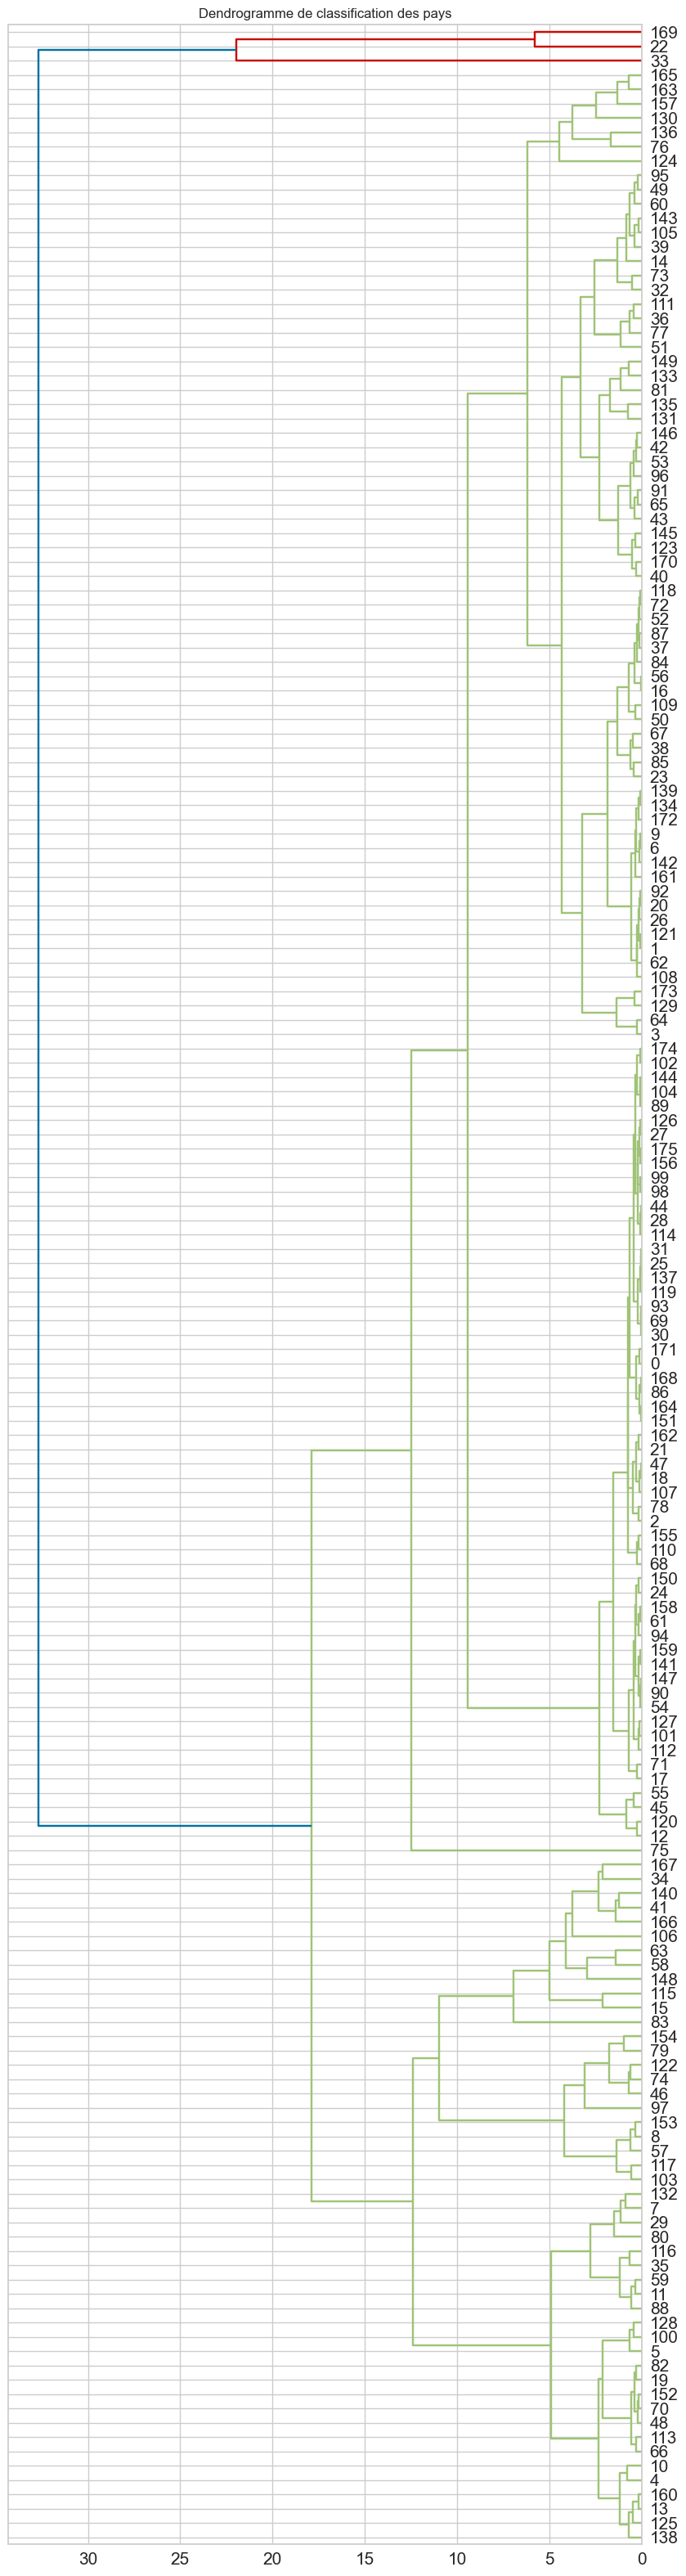

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10,40))
_ = dendrogram(Z, ax=ax, orientation = "left")
plt.title("Dendrogramme de classification des pays")
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)

In [35]:
nombre_clusters=7

In [36]:
clusters = fcluster(Z, nombre_clusters, criterion='maxclust')
clusters

array([4, 4, 4, 4, 1, 1, 4, 1, 2, 4, 1, 1, 4, 1, 4, 3, 4, 4, 4, 1, 4, 4,
       6, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 7, 3, 1, 4, 4, 4, 4, 4, 3, 4, 4,
       4, 4, 2, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 2, 3, 1, 4, 4, 4, 3, 4, 4,
       1, 4, 4, 4, 1, 4, 4, 4, 2, 5, 4, 4, 4, 2, 1, 4, 1, 3, 4, 4, 4, 4,
       1, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 1, 4, 4, 2, 4, 4, 3, 4, 4, 4,
       4, 4, 4, 1, 4, 3, 1, 2, 4, 4, 4, 4, 2, 4, 4, 1, 4, 4, 1, 4, 4, 4,
       1, 4, 4, 4, 4, 4, 1, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 1, 2,
       2, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 3, 3, 4, 6, 4, 4, 4, 4, 4, 4],
      dtype=int32)

In [37]:
cluster = AgglomerativeClustering(n_clusters=nombre_clusters, affinity='euclidean', linkage='ward')
clusters = pd.DataFrame(clusters, columns=['cluster'])
tableau_clusters = pd.merge(clusters,tableau_donnees_2020_v3["Area"],left_index=True,right_index=True)
tableau_clusters.rename(columns={"cluster" : "Cluster"},inplace=True)
tableau_clusters.sort_values(by = "Cluster",ascending=False)

,Cluster,Area
33,7,China
22,6,Brazil
169,6,United States of America
75,5,India
112,4,Namibia
...,...,...
35,1,"China, Macao SAR"
100,1,Malaysia
132,1,Qatar
128,1,Peru


In [38]:
tableau_resultats_PCA = pd.DataFrame(X_proj,columns=["F1","F2","F3","F4","F5","F6","F7","F8"])
tableau_resultats_PCA

,F1,F2,F3,F4,F5,F6,F7,F8
0,-0.696480,-1.018115,0.660261,0.407095,-0.126265,0.076913,-0.043818,-1.277596e-16
1,-0.668051,-0.237175,0.213919,-0.207891,-0.088580,-0.042290,-0.019917,-1.440230e-16
2,-0.593336,-0.780762,0.593708,0.306684,0.023183,-0.076221,-0.094214,-9.139834e-17
3,-0.321030,-0.936454,0.203962,0.164572,-0.449429,0.551635,-0.012070,-9.749224e-17
4,-0.348646,1.771069,-0.930627,-2.190671,0.477700,-0.161171,0.267560,-1.987991e-16
...,...,...,...,...,...,...,...,...
171,-0.633001,-0.980348,0.570542,0.404652,-0.166195,0.016731,-0.042675,-1.311705e-16
172,-0.764475,-0.466483,0.413692,-0.031535,-0.135257,-0.092172,-0.050032,-7.744452e-17
173,0.391011,-0.618898,0.212264,-0.164557,-0.060822,0.601303,-0.247440,6.365588e-17
174,-0.683005,-0.976509,0.610100,0.382659,-0.232328,-0.120145,-0.034485,-8.152185e-17


In [39]:
tableau_clusters = pd.merge(tableau_resultats_PCA,tableau_clusters,left_index=True,right_index=True)
tableau_clusters

,F1,F2,F3,F4,F5,F6,F7,F8,Cluster,Area
0,-0.696480,-1.018115,0.660261,0.407095,-0.126265,0.076913,-0.043818,-1.277596e-16,4,Afghanistan
1,-0.668051,-0.237175,0.213919,-0.207891,-0.088580,-0.042290,-0.019917,-1.440230e-16,4,Albania
2,-0.593336,-0.780762,0.593708,0.306684,0.023183,-0.076221,-0.094214,-9.139834e-17,4,Algeria
3,-0.321030,-0.936454,0.203962,0.164572,-0.449429,0.551635,-0.012070,-9.749224e-17,4,Angola
4,-0.348646,1.771069,-0.930627,-2.190671,0.477700,-0.161171,0.267560,-1.987991e-16,1,Antigua and Barbuda
...,...,...,...,...,...,...,...,...,...,...
171,-0.633001,-0.980348,0.570542,0.404652,-0.166195,0.016731,-0.042675,-1.311705e-16,4,Uzbekistan
172,-0.764475,-0.466483,0.413692,-0.031535,-0.135257,-0.092172,-0.050032,-7.744452e-17,4,Vanuatu
173,0.391011,-0.618898,0.212264,-0.164557,-0.060822,0.601303,-0.247440,6.365588e-17,4,Viet Nam
174,-0.683005,-0.976509,0.610100,0.382659,-0.232328,-0.120145,-0.034485,-8.152185e-17,4,Zambia


In [40]:
composantes_gardees = ["F1","F2","F3","F4","Cluster","Area"]
tableau_clusters_final = tableau_clusters[composantes_gardees]
tableau_clusters_final.sort_values(by = "Cluster",ascending=False)

,F1,F2,F3,F4,Cluster,Area
33,20.057561,-6.501293,-2.894889,-0.912985,7,China
22,7.307412,5.241237,5.917877,-0.047453,6,Brazil
169,10.872146,7.300564,5.554454,1.404633,6,United States of America
75,3.862804,-3.234857,1.675294,0.376291,5,India
112,-0.721773,-0.582937,0.424877,0.191588,4,Namibia
...,...,...,...,...,...,...
35,-0.312020,1.606639,-1.275846,-0.382255,1,"China, Macao SAR"
100,0.279602,0.907519,-0.201757,-1.291693,1,Malaysia
132,-0.071684,1.843633,-1.753442,-0.069140,1,Qatar
128,0.324515,0.955844,-0.208531,-1.706069,1,Peru


In [41]:
tableau_donnees_2020_v4 = pd.merge(tableau_donnees_2020_v3,tableau_clusters_final,on="Area")
tableau_donnees_2020_v4

,Area,Country Code,Nombre habitants,Production,Importations,Exportations,Variation de stock,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité intérieure (milliers de tonnes),PIB par habitant,F1,F2,F3,F4,Cluster
0,Afghanistan,AFG,-0.029500,-0.270579,-0.242073,-0.225655,-0.211746,-1.170725,-0.273748,-0.687835,-0.696480,-1.018115,0.660261,0.407095,4
1,Albania,ALB,-0.260474,-0.275788,-0.283545,-0.225655,-0.191093,-0.127956,-0.282308,-0.440164,-0.668051,-0.237175,0.213919,-0.207891,4
2,Algeria,DZA,0.002039,-0.175331,-0.391374,-0.223453,-0.160115,-0.914225,-0.186601,-0.541562,-0.593336,-0.780762,0.593708,0.306684,4
3,Angola,AGO,-0.068340,-0.261650,0.537612,-0.225655,-0.191093,-0.816002,-0.190491,-0.635125,-0.321030,-0.936454,0.203962,0.164572,4
4,Antigua and Barbuda,ATG,-0.278285,-0.280997,-0.366491,-0.225655,-0.191093,2.963458,-0.295535,0.039081,-0.348646,1.771069,-0.930627,-2.190671,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,Uzbekistan,UZB,-0.064477,-0.256441,-0.208895,-0.225655,-0.118810,-1.119298,-0.252351,-0.621012,-0.633001,-0.980348,0.570542,0.404652,4
172,Vanuatu,VUT,-0.276945,-0.280625,-0.374785,-0.225655,-0.191093,-0.467347,-0.295924,-0.560467,-0.764475,-0.466483,0.413692,-0.031535,4
173,Viet Nam,VNM,0.344731,0.209755,0.587379,-0.188223,-0.191093,-0.290544,0.300491,-0.529191,0.391011,-0.618898,0.212264,-0.164557,4
174,Zambia,ZMB,-0.161127,-0.261650,-0.304282,-0.205838,-0.036200,-1.125207,-0.267135,-0.663457,-0.683005,-0.976509,0.610100,0.382659,4


In [42]:
tableau_moyennes_clusters = tableau_clusters_final.groupby("Cluster").mean()
tableau_moyennes_clusters

,F1,F2,F3,F4
Cluster,,,,
1,-0.208981,1.204045,-0.692091,-1.116322
2,-0.253523,1.362255,-1.495805,1.653411
3,1.659098,0.294859,-1.494256,0.284602
4,-0.435450,-0.414757,0.334149,0.044232
5,3.862804,-3.234857,1.675294,0.376291
6,9.089779,6.270901,5.736165,0.678590
7,20.057561,-6.501293,-2.894889,-0.912985


<AxesSubplot:ylabel='Cluster'>

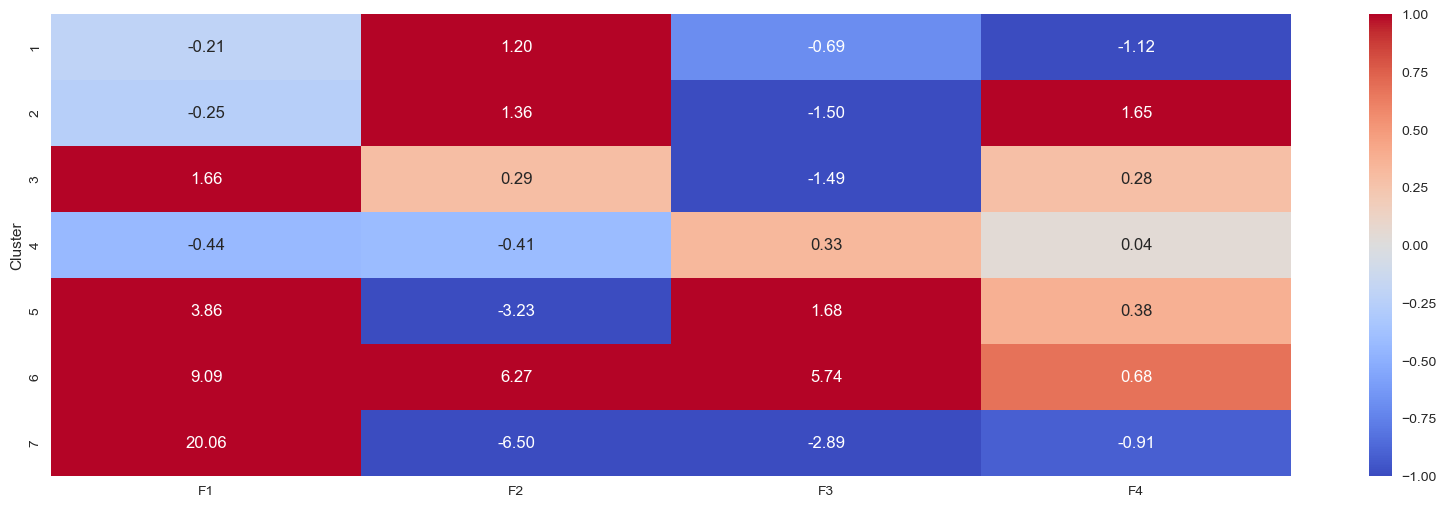

In [43]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(tableau_moyennes_clusters, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

## Tests statistiques

In [44]:
tableau_donnees_2020_v4.describe()

,Nombre habitants,Production,Importations,Exportations,Variation de stock,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité intérieure (milliers de tonnes),PIB par habitant,F1,F2,F3,F4,Cluster
count,1.760000e+02,1.760000e+02,1.760000e+02,1.760000e+02,1.760000e+02,1.760000e+02,1.760000e+02,1.760000e+02,1.760000e+02,1.760000e+02,1.760000e+02,1.760000e+02,176.000000
mean,9.935234e-18,4.510281e-17,-1.135455e-17,3.485217e-17,-2.854409e-17,-2.371840e-16,-1.293158e-17,-1.072375e-17,-2.144749e-17,1.955506e-17,2.523234e-18,-1.766264e-17,3.426136
std,1.002853e+00,1.002853e+00,1.002853e+00,1.002853e+00,1.002853e+00,1.002853e+00,1.002853e+00,1.002853e+00,1.999860e+00,1.242416e+00,1.050918e+00,8.080443e-01,1.173614
min,-2.788431e-01,-2.809971e-01,-3.913741e-01,-2.256550e-01,-6.351194e-01,-1.240201e+00,-2.974806e-01,-7.031925e-01,-8.417700e-01,-6.501293e+00,-3.651968e+00,-2.190671e+00,1.000000
25%,-2.617613e-01,-2.769974e-01,-3.789323e-01,-2.256550e-01,-1.910932e-01,-8.865151e-01,-2.824049e-01,-6.152316e-01,-6.949590e-01,-7.827462e-01,-4.021128e-01,-4.752356e-01,3.000000
50%,-2.174121e-01,-2.545805e-01,-3.084289e-01,-2.256550e-01,-1.910932e-01,-1.734743e-01,-2.537123e-01,-4.408058e-01,-5.054503e-01,-1.470019e-01,2.081128e-01,7.870863e-02,4.000000
75%,-7.074378e-02,-1.626807e-01,-4.300426e-02,-1.959297e-01,-1.497884e-01,5.604891e-01,-1.524617e-01,1.328249e-01,-6.711852e-02,6.614524e-01,5.728700e-01,4.051847e-01,4.000000
max,9.147547e+00,8.332283e+00,9.524725e+00,8.685348e+00,1.130196e+01,2.963458e+00,9.406628e+00,5.446616e+00,2.005756e+01,7.300564e+00,5.917877e+00,3.570229e+00,7.000000


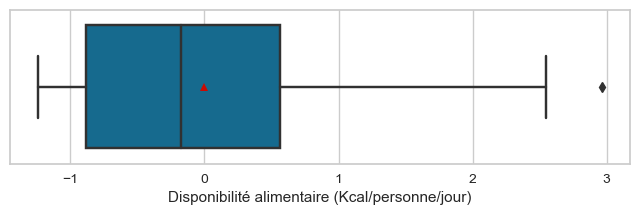

In [45]:
plt.figure(figsize=(8,2))
sns.boxplot(data=tableau_donnees_2020_v4, x='Disponibilité alimentaire (Kcal/personne/jour)', showmeans=True)
plt.show()

H0 : les moyennes des clusters en disponibilité sont égales
H1 : il existe au moins deux groupes dont les moyennes sont différentes

In [46]:
st.f_oneway(
    tableau_donnees_2020_v4["Disponibilité alimentaire (Kcal/personne/jour)"],
    tableau_donnees_2020_v4["Cluster"],
    axis=0)

F_onewayResult(statistic=866.9270017302696, pvalue=9.848170741351569e-97)

## K-Means

In [47]:
pays_impactants = tableau_donnees_2020_v4.loc[
    (tableau_donnees_2020_v4["Country Code"] == 'BRA') | 
    (tableau_donnees_2020_v4["Country Code"] == 'USA') | 
    (tableau_donnees_2020_v4["Country Code"] == 'CHN') |
    (tableau_donnees_2020_v4["Country Code"] == 'IND')]
pays_impactants

,Area,Country Code,Nombre habitants,Production,Importations,Exportations,Variation de stock,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité intérieure (milliers de tonnes),PIB par habitant,F1,F2,F3,F4,Cluster
22,Brazil,BRA,1.082945,5.068910,-0.370638,8.685348,0.304564,2.024503,3.742429,-0.352823,7.307412,5.241237,5.917877,-0.047453,6
33,China,CHN,9.147547,7.926362,9.524725,1.137308,11.301957,-0.111505,9.406628,-0.194439,20.057561,-6.501293,-2.894889,-0.912985,7
75,India,IND,8.562705,1.057317,-0.391374,-0.216848,-0.191093,-1.124728,1.099992,-0.613896,3.862804,-3.234857,1.675294,0.376291,5
169,United States of America,USA,1.841805,8.332283,0.168506,8.313231,-0.635119,2.428418,7.235721,2.601768,10.872146,7.300564,5.554454,1.404633,6


On a quatre pays qui se détachent du lot et qu'il est nécessaire de retirer des données pour poursuivre l'analyse.

In [48]:
tableau_donnees_2020_matrice_v2 = pd.DataFrame(tableau_donnees_2020_matrice)
tableau_donnees_2020_matrice_v2.drop([22,33,75,169],inplace=True)
tableau_donnees_2020_matrice_v2

,0,1,2,3,4,5,6,7
0,38928350.0,28.0,36.0,0.0,-2.0,5.98,62.0,517.449409
1,2877800.0,14.0,26.0,0.0,0.0,71.27,40.0,5268.863092
2,43851040.0,284.0,0.0,1.0,3.0,22.04,286.0,3323.609265
3,32866270.0,52.0,224.0,0.0,0.0,28.19,276.0,1528.660485
4,97930.0,0.0,6.0,0.0,0.0,264.83,6.0,14462.862740
...,...,...,...,...,...,...,...,...
171,33469200.0,66.0,44.0,0.0,7.0,9.20,117.0,1799.406657
172,307140.0,1.0,4.0,0.0,0.0,50.02,5.0,2960.933267
173,97338580.0,1319.0,236.0,17.0,0.0,61.09,1538.0,3560.928772
174,18383960.0,52.0,21.0,9.0,15.0,8.83,79.0,985.132617


In [49]:
scaler = StandardScaler()
tableau_donnees_2020_scaled_v2 = scaler.fit_transform(tableau_donnees_2020_matrice_v2)
tableau_donnees_2020_scaled_v2

array([[ 0.34306171, -0.49187206, -0.27128976, ..., -1.17739686,
        -0.46984188, -0.68611478],
       [-0.53278558, -0.5101162 , -0.33046023, ..., -0.11166056,
        -0.49686094, -0.4360174 ],
       [ 0.46265835, -0.1582649 , -0.48430347, ..., -0.9152476 ,
        -0.19473864, -0.53840858],
       ...,
       [ 1.76213691,  1.19049843,  0.91211978, ..., -0.27782989,
         1.34289193, -0.52591694],
       [-0.15606377, -0.46059639, -0.36004547, ..., -1.13087597,
        -0.44896351, -0.66149761],
       [-0.24160736, -0.44104909, -0.47838643, ..., -1.02265371,
        -0.46247304, -0.63717576]])

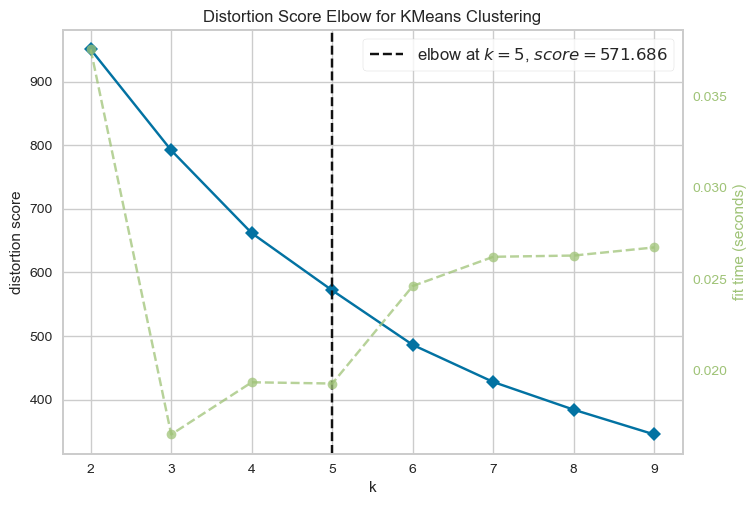

KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=9, random_state=4), k=(2, 10))

In [50]:
X = tableau_donnees_2020_scaled_v2
kelbow_visualizer(KMeans(random_state=4), X, k=(2,10))

In [51]:
kmeans = KMeans(n_clusters=5,init='k-means++').fit(tableau_donnees_2020_scaled_v2)
centroids = kmeans.cluster_centers_
print(centroids)

[[-0.47334084 -0.31768395 -0.06222074 -0.08915751 -0.09306012  0.94780343
  -0.29794784  0.79550196]
 [-0.13990682 -0.42628003 -0.31303782 -0.28846038 -0.19352475 -0.68043956
  -0.41355215 -0.53917765]
 [ 2.00919476  2.21161187  3.33050171  0.82417502  3.45187481  0.25605263
   2.80402695  0.6561346 ]
 [ 1.27023326  1.91143161  0.33027676  0.34832677 -0.14131824  0.49419913
   1.78242938 -0.04943782]
 [ 0.40781924  1.87769443  0.75827654  6.24561088  0.27435965 -0.20992572
   0.5323199   0.62194043]]


In [52]:
kmeans.labels_

array([1, 1, 1, 1, 0, 3, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 0, 0, 3, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 3, 1, 0, 1, 1, 1, 0, 2, 0, 0, 1, 1, 2, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 3, 3, 1, 0, 0, 3, 0, 2, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 3, 1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 3, 1,
       0, 1, 4, 0, 0, 1, 1, 1, 1, 0, 1, 2, 0, 1, 1, 3, 3, 4, 0, 0, 3, 1,
       0, 3, 1, 0, 1, 3, 1, 1, 0, 1, 1, 0, 1, 2, 3, 1, 1, 0, 0, 0, 1, 1,
       4, 1, 1, 0, 1, 1, 3, 1, 3, 0, 2, 1, 1, 1, 1, 3, 1, 1])

In [53]:
clusters_kmeans = pd.DataFrame(kmeans.labels_, columns=['Cluster KMeans'])
clusters_kmeans.groupby("Cluster KMeans").value_counts()

Cluster KMeans
0    54
1    90
2     7
3    18
4     3
dtype: int64

In [54]:
tableau_donnees_2020_v2.drop([22,33,75,169],axis=0,inplace=True)
tableau_donnees_2020_v2.reset_index(inplace=True)
tableau_donnees_2020_v2

,index,Area,Country Code,Nombre habitants,Production,Importations,Exportations,Variation de stock,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité intérieure (milliers de tonnes),PIB par habitant
0,0,Afghanistan,AFG,38928350.0,28.0,36.0,0.0,-2.0,5.98,62.0,517.449409
1,1,Albania,ALB,2877800.0,14.0,26.0,0.0,0.0,71.27,40.0,5268.863092
2,2,Algeria,DZA,43851040.0,284.0,0.0,1.0,3.0,22.04,286.0,3323.609265
3,3,Angola,AGO,32866270.0,52.0,224.0,0.0,0.0,28.19,276.0,1528.660485
4,4,Antigua and Barbuda,ATG,97930.0,0.0,6.0,0.0,0.0,264.83,6.0,14462.862740
...,...,...,...,...,...,...,...,...,...,...,...
167,171,Uzbekistan,UZB,33469200.0,66.0,44.0,0.0,7.0,9.20,117.0,1799.406657
168,172,Vanuatu,VUT,307140.0,1.0,4.0,0.0,0.0,50.02,5.0,2960.933267
169,173,Viet Nam,VNM,97338580.0,1319.0,236.0,17.0,0.0,61.09,1538.0,3560.928772
170,174,Zambia,ZMB,18383960.0,52.0,21.0,9.0,15.0,8.83,79.0,985.132617


In [55]:
tableau_clusters_kmeans = pd.merge(clusters_kmeans,tableau_donnees_2020_v2["Country Code"],left_index=True,right_index=True)
tableau_clusters_kmeans

,Cluster KMeans,Country Code
0,1,AFG
1,1,ALB
2,1,DZA
3,1,AGO
4,0,ATG
...,...,...
167,1,UZB
168,1,VUT
169,3,VNM
170,1,ZMB


In [68]:
tableau_donnees_2020_v4.to_csv("tableau_donnees_presentation.csv")
tableau_clusters_kmeans.to_csv("tableau_kmeans_presentation.csv")